# A pos Experiment in a Jupyter-Notebook

In [1]:
# install dependencies (need to be run once)
!pip install ipylivebash
!pip install numpy

In [2]:
# required to display live output of bash cells
import ipylivebash

## Variable Definitions

The following cell specifies the global variables. These variables are shared across all experiment nodes participating in an experiment.

In [3]:
%%writefile ./global-variables.yml

repo:                                                                                                                   
  moongen: 'https://github.com/emmericp/MoonGen'                                                                        
  commit: '7746ff2f0afdbb222aa9cb220b48355e2d19552b'  

Overwriting ./global-variables.yml


The following cells specify the local variables. These variables are exclusive for a specific experiment node. 

Typically, a seperate local variable file for each participating experiment node is created.

In [4]:
%%writefile ./loadgen-local-variables.yml

interface:                                                                                                              
  rx: '0'                                                                                                               
  tx: '1' 

Overwriting ./loadgen-local-variables.yml


In [5]:
%%writefile ./dut-local-variables.yml

interface:                                                                                                              
  rx: '0'                                                                                                               
  tx: '1' 

Overwriting ./dut-local-variables.yml


The following cell specifies the loop variables. These variables parameterize the task that describes the actual experiment. A typical parameter to investigate in networked experiments would be different packet rates and packet sizes.

In [6]:
%%writefile ./loop-variables.yml

pkt_sizes: [64, 1500]                                                                                                                       
rates: [1000, 2000, ..., 10000]  

Overwriting ./loop-variables.yml


## Setup Scripts

The following cells specify the setup scripts. These scripts are used to configure the participating experiment nodes. 

Typically, a seperate setup file for each participating experiment node is created. Typical tasks to perform in this stage of the experiment is the installation of dependencies or the configuration of addresses.

In [7]:
%%writefile dut-setup.sh
#!/bin/bash

# get global variables                                                                                                  
GIT_REPO=$(pos_get_variable -g repo/moongen)                                                                      
COMMIT_ID=$(pos_get_variable -g repo/commit)                                                                      
                                                                                                                        
# clone repo and install MoonGen                                                                                        
git clone --recursive $GIT_REPO /root/moongen                                                                           
cd /root/moongen                                                                                                        
git checkout $COMMIT_ID                                                                                                 
./build.sh                                                                                                              
./setup-hugetlbfs.sh

Overwriting dut-setup.sh


In [8]:
%%writefile loadgen-setup.sh
#!/bin/bash

# get global variables                                                                                                  
GIT_REPO=$(pos_get_variable -g repo/moongen)                                                                      
COMMIT_ID=$(pos_get_variable -g repo/commit)                                                                      
                                                                                                                        
# clone repo and install MoonGen                                                                                        
git clone --recursive $GIT_REPO /root/moongen                                                                           
cd /root/moongen                                                                                                        
git checkout $COMMIT_ID                                                                                                 
./build.sh                                                                                                              
./setup-hugetlbfs.sh

Overwriting loadgen-setup.sh


## Task Description Scripts

The following cells specify the actual tasks that perform the individual measurements of an experiment.

Typically, a seperate task description script for each participating experiment node is created. 

In [9]:
%%writefile dut-task-description.sh
#!/bin/bash

# get local variables                                                                                                  
RX=$(pos_get_variable interface/rx)                                                                      
TX=$(pos_get_variable interface/tx)

# loop variables not used on DuT

# synchronize between participating nodes
pos_sync

# run forwarder
pos_run -l forward -- /root/moongen/build/MoonGen /root/moongen/libmoon/examples/l2-forward.lua $RX $TX

# wait for 60s
sleep 60

# kill forwarder
pos_kill -l forward
sleep 5

Overwriting dut-task-description.sh


In [10]:
%%writefile loadgen-task-description.sh
#!/bin/bash

# get local variables                                                                                                  
RX=$(pos_get_variable interface/rx)                                                                      
TX=$(pos_get_variable interface/tx)

# get loop variables
PKT_SZ=$(pos_get_variable -l pkt_sizes)                                                                      
RATE=$(pos_get_variable -l rates) 

# synchronize between participating nodes
pos_sync

# run load generator
pos_run -l generate -- /root/moongen/build/MoonGen /root/moongen/examples/l3-load-latency.lua -r $RATE -s $PKT_SZ $TX $RX

# wait for 60s
sleep 60

# kill load generator
pos_kill -l generate

sleep 1
pos_upload -l histogram.csv

Overwriting loadgen-task-description.sh


## Experiment Script

The experiment script is the entry point of a pos experiment (similar to the main function of C-based languages). This script reflects the high-level description of the experiment.

Typical steps in this main script involve:
* Freeing of experiment nodes (if nodes were not freed during previous experiment)
* Allocation of experiment nodes for an experiment
* Setting the previously defined variables
* Choosing an OS image and rebooting the experiment nodes
* Launching setup scripts
* Launching the task descriptions to perform the measurements
* Freeing the hosts to make them available for other experiments

In [11]:
%%livebash

set -x
set -e

DUT="dogecoincash"
LOADGEN="dogecoin"

# free experiment nodes
pos allocations free $DUT
pos allocations free $LOADGEN

# allocate experiment nodes                                                                                             
pos allocations allocate --duration 10 $DUT $LOADGEN | tee allocation.txt                                                                    
                                                                                                                        
# load variables                                                                                                        
pos allocations set_variables $DUT --as-global ./global-variables.yml # global vars                                     
pos allocations set_variables $DUT ./dut-local-variables.yml          # local vars 
pos allocations set_variables $LOADGEN ./loadgen-local-variables.yml  # local vars 
pos allocations set_variables $DUT --as-loop ./loop-variables.yml     # loop vars 

# configure & reboot nodes                                                                                              
pos nodes image $DUT debian-buster                                                                                    
pos nodes image $LOADGEN debian-buster                                                                                
pos nodes reset $DUT --non-blocking                                                                                     
pos nodes reset $LOADGEN --non-blocking                                                                                 
                                                                                                                        
# setup nodes                                                                                                           
pos commands launch --infile dut-setup.sh --queued $DUT                                                               
pos commands launch --infile loadgen-setup.sh --queued $LOADGEN                                                           
                                                                                                                        
# execute experiment on nodes                                                                                           
pos commands launch --infile dut-task-description.sh --queued --loop $DUT                                                  
pos commands launch --infile loadgen-task-description.sh --blocking --loop $LOADGEN                                            
                                                                                                                        
# free nodes                                                                                                            
pos allocations free $DUT

GridBox(children=(VBox(children=(LogView(),)),), layout=Layout(grid_template_columns='100%', grid_template_row…

In [29]:
import pathlib
import json

allocationpath = ''
with open('allocation.txt') as afile:
    allocationpath = afile.read().split(' ')[-1].replace('\n', '') + '/dogecoin'

print(allocationpath)
    
# extract loop information from files
loop_vars = {}
loop_files = {}
for lfile in pathlib.Path(allocationpath).glob('*.loop'):
    run_key = int(lfile.stem.split('_')[-1].replace('run', ''))
    with open(lfile) as loopfile:
        jobj = json.loads(loopfile.read())
        loop_files[run_key] = jobj
        for k, v in jobj.items():
            if k in loop_vars.keys():
                loop_vars[k].add(v)
            else:
                loop_vars[k] = {v}

list_loop_vars = {}
for k,v in loop_vars.items():
    list_loop_vars[k] = sorted(list(v))
                
print(list_loop_vars)

# extract the measured average tx and rx rates
for outfile in pathlib.Path(allocationpath).glob('*generate*.stdout'):
    run_key = int(outfile.stem.split('_')[-1].replace('run', ''))
    with open(outfile) as stdoutfile:
        for line in stdoutfile:
            if "total" in line and 'RX' in line:
                print(line)
                loop_files[run_key]['rx_avg'] = float(line.split('Mpps')[0].split('(')[0].split(':')[-1])
            if "total" in line and 'TX' in line:
                loop_files[run_key]['tx_avg'] = float(line.split('Mpps')[0].split('(')[0].split(':')[-1])
                
print(loop_files)

rx_output = {}
tx_output = {}
# aggregate over loop vars
for k, v in list_loop_vars.items():
    for val in v:
        rx_output[k + '_' + str(val)] = []
        tx_output[k + '_' + str(val)] = []
        for item, value in loop_files.items():
            if value[k] == val: 
                rx_output[k + '_' + str(val)].append(value['rx_avg'])
                tx_output[k + '_' + str(val)].append(value['tx_avg'])
            
print(tx_output)

/srv/testbed/results/gallenmu/default/2022-10-28_21-18-24_155466/dogecoin
{'rates': [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000], 'pkt_sizes': [64, 1500]}
[Device: id=0] RX: 1.84 (StdDev 0.00) Mpps, 1001 (StdDev 0) Mbit/s (1295 Mbit/s with framing), total 103565402 packets with 7043553312 bytes (incl. CRC)

[Device: id=0] RX: 0.08 (StdDev 0.00) Mpps, 999 (StdDev 0) Mbit/s (1012 Mbit/s with framing), total 4674478 packets with 7030413472 bytes (incl. CRC)

[Device: id=0] RX: 3.68 (StdDev 0.00) Mpps, 2001 (StdDev 0) Mbit/s (2589 Mbit/s with framing), total 206245259 packets with 14025779288 bytes (incl. CRC)

[Device: id=0] RX: 0.17 (StdDev 0.00) Mpps, 1999 (StdDev 0) Mbit/s (2026 Mbit/s with framing), total 9354413 packets with 14069035712 bytes (incl. CRC)

[Device: id=0] RX: 5.25 (StdDev 0.02) Mpps, 2856 (StdDev 10) Mbit/s (3695 Mbit/s with framing), total 277883881 packets with 18897141484 bytes (incl. CRC)

[Device: id=0] RX: 0.25 (StdDev 0.00) Mpps, 2999 (StdDev 0)

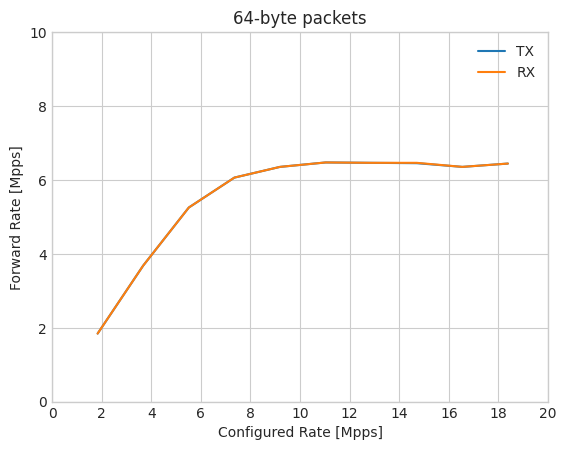

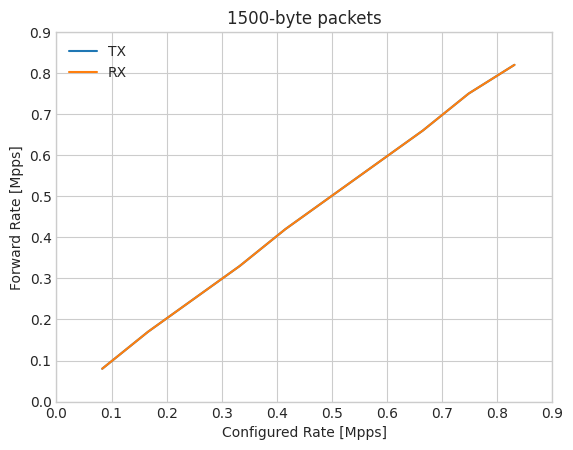

In [53]:
%matplotlib inline

# values are configured in Mbit/s -> convert them to mpps
def convert(liste, pkt_size):
    newlist = []
    for i in liste:
        newlist.append(((i * 1000000) / ((pkt_size+4) * 8))/1000000)
    return newlist

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

fig = plt.figure()
ax = plt.axes()

#print(tx_output["pkt_sizes_64"])
#print(list_loop_vars["rates"])

plt.title("64-byte packets")
plt.xlabel("Configured Rate [Mpps]")
plt.ylabel("Forward Rate [Mpps]")
plt.plot(convert(list_loop_vars["rates"], 64), tx_output["pkt_sizes_64"], label="TX")
plt.plot(convert(list_loop_vars["rates"], 64), rx_output["pkt_sizes_64"], label="RX")
plt.xticks(np.arange(0, 21, 2))
plt.yticks(np.arange(0, 11, 2))
plt.legend()


fig = plt.figure()
ax = plt.axes()

#print(tx_output["pkt_sizes_64"])
#print(list_loop_vars["rates"])

plt.title("1500-byte packets")
plt.xlabel("Configured Rate [Mpps]")
plt.ylabel("Forward Rate [Mpps]")

plt.plot(convert(list_loop_vars["rates"], 1500), tx_output["pkt_sizes_1500"], label="TX")
plt.plot(convert(list_loop_vars["rates"], 1500), rx_output["pkt_sizes_1500"], label="RX")
plt.xticks(np.arange(0, 1, .1))
plt.yticks(np.arange(0, 1, .1))
plt.legend()